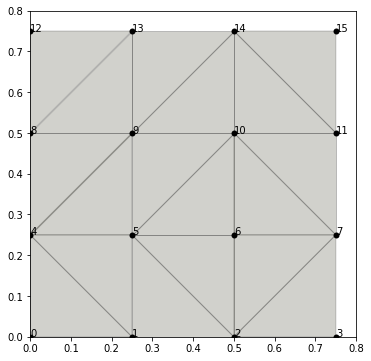

{(4, 1, 5): [(0, 1, 4), (5, 1, 2), (9, 4, 5)], (0, 1, 4): [-1, (4, 1, 5), -1], (5, 1, 2): [(4, 1, 5), -1, (2, 6, 5)], (9, 4, 5): [(9, 8, 4), (4, 1, 5), (10, 9, 5)], (3, 7, 2): [-1, (2, 7, 6), -1], (2, 7, 6): [(3, 7, 2), (6, 7, 10), (2, 6, 5)], (6, 7, 10): [(2, 7, 6), (7, 11, 10), (5, 6, 10)], (2, 6, 5): [(2, 7, 6), (5, 6, 10), (5, 1, 2)], (5, 6, 10): [(2, 6, 5), (6, 7, 10), (10, 9, 5)], (9, 8, 4): [(8, 9, 13), -1, (9, 4, 5)], (10, 9, 5): [(9, 10, 14), (9, 4, 5), (5, 6, 10)], (8, 9, 13): [(9, 8, 4), (14, 13, 9), (12, 8, 13)], (12, 8, 13): [-1, (8, 9, 13), -1], (14, 13, 9): [-1, (8, 9, 13), (9, 10, 14)], (9, 10, 14): [(10, 9, 5), (14, 10, 11), (14, 13, 9)], (7, 11, 10): [-1, (14, 10, 11), (6, 7, 10)], (14, 10, 11): [(9, 10, 14), (7, 11, 10), (14, 11, 15)], (14, 11, 15): [(14, 10, 11), -1, -1]}


In [88]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np




        

def get_edge_to_triangle_connection(T):
    '''
    Function to determine the neighbouring elements of an edge in a triangular mesh
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        edges: dictionary - keys are two node indices, that define a triangles edge
               every key has a list of two values, which are the adjacent triangles 
               to the edge. If the last value is -1, the edge is located at the boundary
               
    '''
    edges = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all current edges
        for iE in range(3):
            edge = (tri[iE], tri[(iE+1)%3])
            
            # Check if edge is already in dictionary
            if (edge in edges) or (edge[::-1] in edges):
                try:
                    edges[edge][1] = tuple(tri)#iTri
                except:
                    edges[edge[::-1]][1] = tuple(tri) #iTri
            else:
                edges.update({edge:[tuple(tri), -1]})
    return edges
            
    
def get_node_to_triangle_connection(T):
    '''
    Function to determine the triangles, that are adjacent to a node in the triangular mesh.
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent triangular elements

    '''
    nodes = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all triangle nodes
        for n in tri:
            if n in nodes:
                nodes[n].append(tuple(tri))
            else:
                nodes.update({n: [tuple(tri)]})
    return nodes
            
            
def get_node_to_edge_connection(E2T):
    '''
    Function determines which edges are adjacent to the mesh nodes
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent mesh-edges
    
    '''
    nodes = {}
    # Loop over all edges
    for edg in E2T:
        # Loop over all nodes of the respective edge
        for n in edg:
            if n in nodes:
                nodes[n].append(edg)
            else:
                nodes.update({n: [edg]})
    return nodes


def get_triangle_to_triangle_connection(E2T):
    '''
    This function creates the connectivity between triangular elements
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: T2T - dictionary - keys are the triangles in node connectivity format
            and values are a list with three entries, that have the neighbouring
            triangle node connectivities or -1 if that edge is at the boundary
    '''
    T2T = {}
    for edg in E2T:
        # Get the triangles that are already found, in "set()" format
        keys = [set(k) for k in T2T.keys()]
        # Check both adjacent triangles to current face 
        for itri, tri in enumerate(E2T[edg]):
            # Boundary edges will have set -1 as second triangle
            if (tri == -1):
                continue   
            # check if triangle exists - if not, add triangle to T2T
            if set(tri) not in keys:
                T2T.update({tri: [-1, -1, -1]})    
            # Check, which indice "edg" has in the current triangle
            # This triangle will then get the neighbor triangle at the
            # same position in the T2T-list
            indEdg = 0
            for iE in range(3):
                edgTri = set((tri[iE], tri[(iE+1)%3]))
                if (set(edg) == edgTri):
                    T2T[tri][indEdg] = E2T[edg][(itri+1)%2]
                indEdg += 1  
    return T2T
        

def get_boundary_nodes(E2T):
    '''
    This function determines, which nodes are located at the boundary
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: list of node indices, that are adjacent to a boundary
    '''
    nodes = []
    for edg in E2T:
        if E2T[edg][1] == -1:
            nodes.append(edg[0])
    return nodes


def get_interior_nodes(bdry_nodes, N):
    '''
    This function determines, which nodes are located in the interior of the domain
    
    Input: bdry_nodes - list with indices of nodes that are adjacent to a boundary
           N - length of global node array
    
    Output: list of node indices, that are not adjacent to a boundary
    '''
    nodes = []
    for i in range(N):
        if i not in bdry_nodes:
            nodes.append(i)
    return nodes



def get_dual_median_connection(iNode, N2T, N2E, E2T):
    '''
    This function creates the dual-median connetivity around a node "iNode"
    '''
    # Collect all edges that are adjacent to this node
    adEdge = N2E[iNode]
    # Collect all triangles that are adjacent to this node
    adTri = N2T[iNode]
    print(adTri)
    


        

x0 = (0, 1)
y0 = (0, 1)
h = 0.25
Nx = int((x0[1]-x0[0])/h)
Ny = int((x0[1]-x0[0])/h)

x = [x0[0] + i*h for j in range(Nx) for i in range(Ny)]
y = [y0[0] + j*h for j in range(Nx) for i in range(Ny)]

# Create triangular mesh
#------------------------------------------------------
T = Triangulation(x, y)
E2T = get_edge_to_triangle_connection(T.triangles[:])
N2T = get_node_to_triangle_connection(T.triangles[:])
N2E = get_node_to_edge_connection(E2T)
T2T = get_triangle_to_triangle_connection(E2T)
bdry_nodes = get_boundary_nodes(E2T)
intr_nodes = get_interior_nodes(bdry_nodes, len(x))


fig = plt.figure()
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

tri_patches = []
for tri in T.triangles:
    poly = Polygon([[x[iNode], y[iNode]] for iNode in tri])
    tri_patches.append(poly)
    
for i in range(len(x)):
    #if(i in intr_nodes):
    ax.plot(x[i], y[i], marker='o', mfc='k',mec='None')
    ax.text(x[i], y[i], str(i))
    
    
ax.set_xlim([0,.8])
ax.set_ylim([0,.8])
tri_patchCol = PatchCollection(tri_patches, alpha=0.2, facecolor=[.1,.1,.0], edgecolor='k')
ax.add_collection(tri_patchCol)
plt.show()

iNode = 9
#create_dual_median_volume(iNode, N2T, N2E, E2T)
print(T2T)

In [46]:
E2T

{(4, 1): [(4, 1, 5), (0, 1, 4)],
 (1, 5): [(4, 1, 5), (5, 1, 2)],
 (5, 4): [(4, 1, 5), (9, 4, 5)],
 (0, 1): [(0, 1, 4), -1],
 (4, 0): [(0, 1, 4), -1],
 (3, 7): [(3, 7, 2), -1],
 (7, 2): [(3, 7, 2), (2, 7, 6)],
 (2, 3): [(3, 7, 2), -1],
 (7, 6): [(2, 7, 6), (6, 7, 10)],
 (6, 2): [(2, 7, 6), (2, 6, 5)],
 (1, 2): [(5, 1, 2), -1],
 (2, 5): [(5, 1, 2), (2, 6, 5)],
 (6, 5): [(2, 6, 5), (5, 6, 10)],
 (9, 4): [(9, 4, 5), (9, 8, 4)],
 (5, 9): [(9, 4, 5), (10, 9, 5)],
 (9, 8): [(9, 8, 4), (8, 9, 13)],
 (8, 4): [(9, 8, 4), -1],
 (12, 8): [(12, 8, 13), -1],
 (8, 13): [(12, 8, 13), (8, 9, 13)],
 (13, 12): [(12, 8, 13), -1],
 (9, 13): [(8, 9, 13), (14, 13, 9)],
 (6, 10): [(5, 6, 10), (6, 7, 10)],
 (10, 5): [(5, 6, 10), (10, 9, 5)],
 (10, 9): [(10, 9, 5), (9, 10, 14)],
 (7, 10): [(6, 7, 10), (7, 11, 10)],
 (7, 11): [(7, 11, 10), -1],
 (11, 10): [(7, 11, 10), (14, 10, 11)],
 (14, 11): [(14, 11, 15), (14, 10, 11)],
 (11, 15): [(14, 11, 15), -1],
 (15, 14): [(14, 11, 15), -1],
 (14, 10): [(14, 10, 11), 

In [63]:
a = (1,2,3)
b = {(3,2,1):1, (2,3,1):2, (1,3,2):3}

keys = [set(bk) for bk in b.keys()]

print(set(a) in keys)


print(keys)

True
[{1, 2, 3}, {1, 2, 3}, {1, 2, 3}]


In [86]:
def get_triangle_to_triangle_connection(E2T):
    '''
    This function creates the connectivity between triangular elements
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: T2T - dictionary - keys are the triangles in node connectivity format
            and values are a list with three entries, that have the neighbouring
            triangle node connectivities or -1 if that edge is at the boundary
    
    '''
    T2T = {}
    for edg in E2T:
        # Get the triangles that are already found, in "set()" format
        keys = [set(k) for k in T2T.keys()]
        
        # Check both adjacent triangles to current face 
        for itri, tri in enumerate(E2T[edg]):
            # Boundary edges will have set -1 as second triangle
            if (tri == -1):
                continue
            
            # check if triangle exists - if not, add triangle to T2T
            if set(tri) not in keys:
                T2T.update({tri: [-1, -1, -1]})
                
            # Check, which indice "edg" has in the current triangle
            # This triangle will then get the neighbor triangle at the
            # same position in the T2T-list
            indEdg = 0
            for iE in range(3):
                edgTri = set((tri[iE], tri[(iE+1)%3]))
                if (set(edg) == edgTri):
                    T2T[tri][indEdg] = E2T[edg][(itri+1)%2]
                indEdg += 1
                
    return T2T
            
            

T2T = get_triangle_to_triangle_connection(E2T)
print(T2T)

{(4, 1, 5): [(0, 1, 4), (5, 1, 2), (9, 4, 5)], (0, 1, 4): [-1, (4, 1, 5), -1], (5, 1, 2): [(4, 1, 5), -1, (2, 6, 5)], (9, 4, 5): [(9, 8, 4), (4, 1, 5), (10, 9, 5)], (3, 7, 2): [-1, (2, 7, 6), -1], (2, 7, 6): [(3, 7, 2), (6, 7, 10), (2, 6, 5)], (6, 7, 10): [(2, 7, 6), (7, 11, 10), (5, 6, 10)], (2, 6, 5): [(2, 7, 6), (5, 6, 10), (5, 1, 2)], (5, 6, 10): [(2, 6, 5), (6, 7, 10), (10, 9, 5)], (9, 8, 4): [(8, 9, 13), -1, (9, 4, 5)], (10, 9, 5): [(9, 10, 14), (9, 4, 5), (5, 6, 10)], (8, 9, 13): [(9, 8, 4), (14, 13, 9), (12, 8, 13)], (12, 8, 13): [-1, (8, 9, 13), -1], (14, 13, 9): [-1, (8, 9, 13), (9, 10, 14)], (9, 10, 14): [(10, 9, 5), (14, 10, 11), (14, 13, 9)], (7, 11, 10): [-1, (14, 10, 11), (6, 7, 10)], (14, 10, 11): [(9, 10, 14), (7, 11, 10), (14, 11, 15)], (14, 11, 15): [(14, 10, 11), -1, -1]}


In [81]:
edg = (1,2)
E2T = {(1,2): [(1,2,3),(4,2,1)]}
tri = E2T[edg][0]

indEdge = 0
for iE in range(3):
    edgTri = set((tri[iE], tri[(iE+1)%3]))
    
    if (set(edg) == edgTri):
        
    
    
    

{1, 2}
{2, 3}
{1, 3}
